In [1]:
# imports
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
from scipy.stats import sem, zscore
from sklearn.decomposition import PCA
from tslearn.clustering import TimeSeriesKMeans

from fcutils.plot.elements import plot_mean_and_error
from fcutils.plot.figure import calc_nrows_ncols
sys.path.append("./")

fld = Path(os.getcwd()).parent
sys.path.append(str(fld))

from electrophysiology.utils import load_rec_data, get_locomotion_onset_times

# cache = Path("/Users/federicoclaudi/Desktop/APA")
cache = Path("/Users/federicoclaudi/Desktop/neuropixels")
tracking_files = cache.glob("*.parquet")
recordings = [f.stem for f in tracking_files if not f.stem.startswith("._")]
len(recordings)



18

### Load all units

In [2]:
DeltaT = 1000 # time before/after frame


units_traces = {}

for i, rec in enumerate(recordings):
    print(f"Doing {i+1} of {len(recordings)}")
    tracking, units = load_rec_data(cache, rec)
    units_names = units.columns

    if len(units.columns) == 0:
        continue

    right_fl_onsets = get_locomotion_onset_times(tracking, "right_fl", cutoff=1500)
    left_fl_onsets = get_locomotion_onset_times(tracking, "left_fl", cutoff=1500)
    if len(right_fl_onsets) == 0 or len(left_fl_onsets) == 0:
        continue

    for i, name in enumerate(units_names):
        alltraces = []
        for timepoints in  right_fl_onsets, left_fl_onsets:
                traces = []
                for frame in timepoints:
                    trace = units[name].values[frame-DeltaT:frame+DeltaT]


                    if len(trace) < 2*DeltaT:
                        continue
                    traces.append(trace)
                    

                alltraces.extend(traces)
        units_traces[rec+"_"+name] = alltraces


Doing 1 of 18
Doing 2 of 18
Doing 3 of 18
Doing 4 of 18
Doing 5 of 18
Doing 6 of 18
Doing 7 of 18
Doing 8 of 18
Doing 9 of 18
Doing 10 of 18
Doing 11 of 18
Doing 12 of 18
Doing 13 of 18
Doing 14 of 18
Doing 15 of 18
Doing 16 of 18
Doing 17 of 18
Doing 18 of 18


## Numbers
TODO
Get number of units, mice, recordings...

In [3]:
# TODO get stuff


## PSTH analysis

1. Compute the PSTH (average time-aligned trace) of each unit by taking the average of traces aligned to movement onset. z-score each PSTH, and stack em in a matrix Z.


2. Use the "elbow method" to estimate the number of clusters required. Briefly, do Kmeans clustering with different numbers of clusters. The more clusters the less the error (SSE). Find an elbow in the plot of SSE vs num clusters; similar to this: Based on this paper: https://elifesciences.org/articles/70129#s4)

3. Cluster using KMeans for time-series data based on the number of clusters found with the previous step

#### Compute PSTH
And plto all PSTH in a heatmap.

Z: (304, 2000)


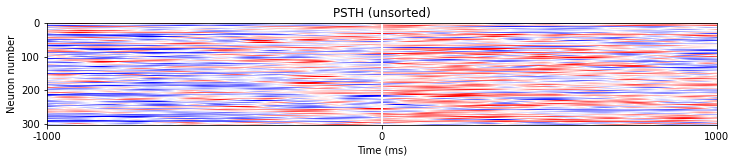

In [32]:
Z = zscore(np.vstack(
    [np.mean(x, 0) for x in units_traces.values()]
), 1)
print(f"Z: {Z.shape}")

# plot PSTH as heatmap
f, ax = plt.subplots(figsize=(12, 10))
ax.imshow(Z, cmap="bwr", clim=[-1.5, 1.5])
ax.axvline(1000, lw=2, color="white")
_ = ax.set(xlabel="Time (ms)", xticks=[0, 1000, 2000], xticklabels=[-1000, 0, 1000], ylabel="Neuron number", title="PSTH (unsorted)")


In [144]:
# variance_threshold = 70

# # Fit PCA and get fraction of variance explained by each PC
# pca = PCA(n_components=40).fit(Z)
# varexplained = np.cumsum(pca.explained_variance_ratio_) * 100
# n_clusters = np.where(varexplained > variance_threshold)[0][0]  # Number of clusters = number of PC to explain enough variance


# # find "elbow" index
# elbow = find_elbow(varexplained)
# print(f"Need to use {n_clusters} clusters")

# f, ax = plt.subplots(figsize=(12, 8))
# ax.plot(varexplained, lw=4, color="black")
# ax.axhline(variance_threshold, ls=":", color="red")
# ax.axvline(n_clusters, ls=":", color="red")
# _ = ax.set(xlabel="PC #", ylabel="Fraction variance explained", ylim=[0, 100])

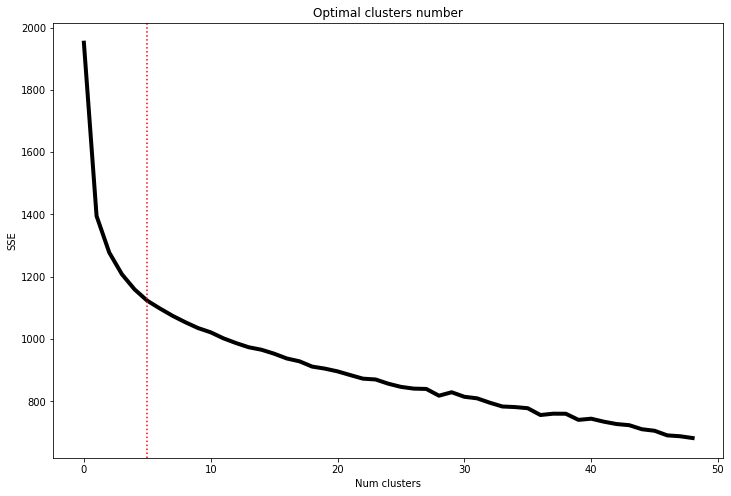

In [143]:
# use the "elbow-method" to evaluate the find number of clusters based on the SSE of the clustering
n_clusters = 5  # the value 5 was decided by eye based on the plot below
sse = []
for k in np.arange(1, 40):
    km = TimeSeriesKMeans(n_clusters=k, max_iter=100, metric="euclidean", n_jobs=-1, n_init=5).fit(Z)
    sse.append(km.inertia_)

f, ax = plt.subplots(figsize=(12, 8))

ax.plot(sse, lw=4, color="black")
ax.axvline(n_clusters, color="red", ls=":")
_ = ax.set(xlabel="Num clusters", ylabel="SSE", title="Optimal clusters number")


/opt/miniconda3/envs/apa/lib/python3.8/site-packages/tslearn/utils/utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 304 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


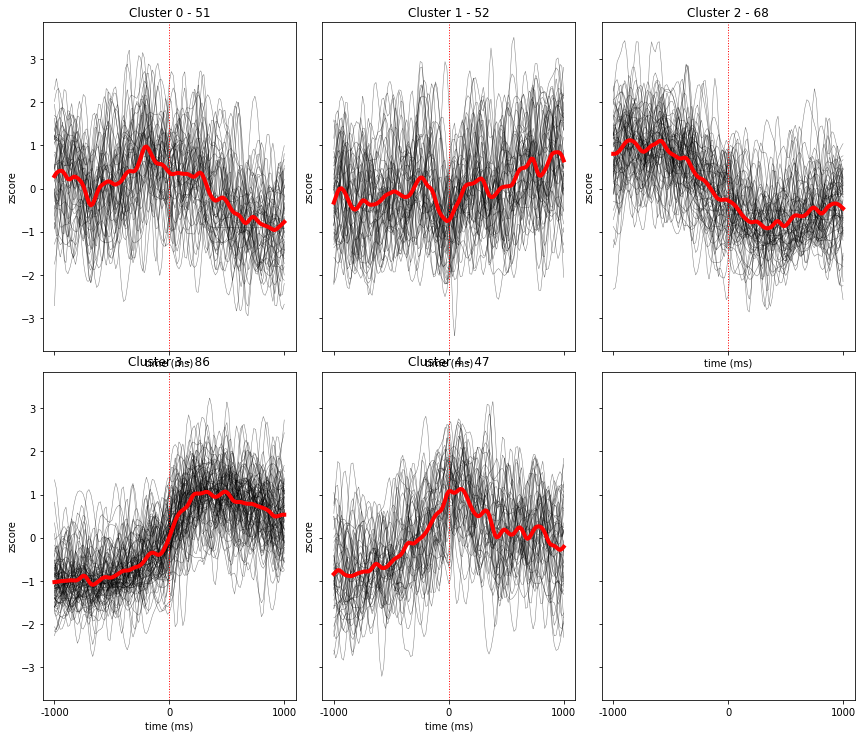

In [142]:
# K-means clustering
km = TimeSeriesKMeans(n_clusters=n_clusters, max_iter=100, metric="euclidean", n_jobs=-1, n_init=5).fit(Z)
representatives = km.cluster_centers_[:, :, 0]
transformed = km.predict(Z)

nrows, ncols = calc_nrows_ncols(n_clusters, aspect=(12, 10))
f, axes = plt.subplots(nrows, ncols, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()
f.tight_layout()

# plot individual traces
for i, label in enumerate(transformed):
    axes[label].plot(Z[i, :], lw=0.5, color="black", alpha=.5)

# plot average trace
for i in np.arange(0, n_clusters):
    axes[i].plot(representatives[i, :], lw=4, color="red")
    axes[i].set(title=f"Cluster {i} - {len(np.where(transformed == i)[0])}", 
            xticks=[0, 1000, 2000], 
            xticklabels=[-1000, 0, 1000], 
            xlabel="time (ms)", ylabel="zscore"
    )
    axes[i].axvline(1000, lw=1, color="red", ls=":")

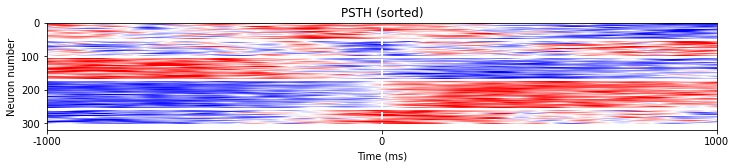

In [147]:
# replot heatmap of all PSTH, but sorting units by their cluster ID

# get the number of cells in each clusters
n = [len(np.where(transformed == i)[0]) for i in range(n_clusters)]
demarcators = np.cumsum(n)

Z_sorted = Z[np.argsort(transformed), :]
f, ax = plt.subplots(figsize=(12, 10))
ax.imshow(Z_sorted, cmap="bwr", clim=[-1.5, 1.5])
ax.axvline(1000, lw=2, color="white", ls="--")

for dm in demarcators:
    ax.axhline(dm, lw=2, color="white")

_ = ax.set(xlabel="Time (ms)", xticks=[0, 1000, 2000], xticklabels=[-1000, 0, 1000], ylabel="Neuron number", title="PSTH (sorted)")


### Identify significant clusters
Some clusters will correspond to no significant modulation. Find clusters whose "representative" indicates significant peri-stimulus modulation.